## Imports

In [49]:
import numpy as np
import networkx as nx
from qibo import matrices
from qibo.hamiltonians import Hamiltonian
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

## MAXcut Hamiltonian

In [29]:
def maxcut(nqubits, norm=2, random_graph=False):
    """Builds maxcut hamiltonian"""
    if random_graph:
        aa = np.random.randint(1, nqubits*(nqubits-1)/2+1)
        graph = nx.random_graphs.dense_gnm_random_graph(nqubits, aa)
        V = nx.adjacency_matrix(graph)

    ham = np.zeros(shape=(2**nqubits,2**nqubits), dtype=np.complex128)
    for i in range(nqubits):
        for j in range(nqubits):
            h = np.eye(1)
            for k in range(nqubits):
                if (k == i) ^ (k == j):
                    h = np.kron(h, matrices.Z)
                else:
                    h = np.kron(h, matrices.I)            
            M = np.eye(2**nqubits) - h
            if random_graph:
                ham += V[i,j] * M
            else:
                ham += M
    matrix = - 1/norm * ham
    
    return Hamiltonian(nqubits, matrix, numpy=True)

def Qu(beta, r, eps=1e-3):
    return beta + np.log(r/eps) / np.log(np.e + np.log(r/eps)/beta)

## Cross-check results and plots

In [44]:
%%time
bstep = 5
K = 0.3
normE = 40
ntemp = 20
reali = 100
nmax = 9

Q = np.zeros(shape=(nmax-1, ntemp))
Qn = np.zeros(shape=(nmax-1, ntemp))
Qaa = np.zeros(shape=(nmax-1, ntemp))
Qeff = np.zeros(shape=(nmax-1, ntemp))

for n in range(2, nmax+1):

    print("n =",n)
    
    for a in range(2, reali+1):
        H = maxcut(n, norm=normE, random_graph=True)
        energy = H.eigenvalues()
        lmin = np.min(energy)
        lmax = np.max(energy)

        for p in range(1, ntemp+1):
            bh = p * bstep
            r = np.int64(np.round(K * bh))            
            beta = bh/r*np.ones(r) * np.arange(1, r+1)

            Qbeta = np.zeros(r)
            for i in range(1, r+1):
                if i == 1:
                    Qbeta[i-1] = Qu(beta[i-1], r)
                else:
                    Qbeta[i-1] = Qu(beta[i-1]-beta[i-2], r)
                Qbeta[i-1] = np.ceil(Qbeta[i-1])

            Qr = Qbeta[0]
            Qeffr = 1

            for f in range(1, r):    
                Zbeta = sum([np.exp(-beta[f-1]*energy[i-1]) for i in range(1, 2**n+1)])
                Psbeta = Zbeta / np.exp(-beta[f-1]*lmin) / 2**n
                Qr += Psbeta * Qbeta[f]
                Qeffr += Psbeta

            Zbeta = sum([np.exp(-beta[r-1]*energy[i]) for i in range(0, 2**n)])
            Psbeta = Zbeta / np.exp(-beta[r-1]*lmin) / 2**n

            Qeff[n-2, p-1] += np.real(Qeffr * Qu(bh/r, r))
            Q[n-2,p-1] += np.real(1/Psbeta * Qr)
            Qn[n-2,p-1] += np.real(1/Psbeta * Qu(bh, 1))
            Qaa[n-2,p-1] += np.real(np.sqrt(1/Psbeta) * Qu(bh, 1))

Q /= reali
Qn /= reali
Qaa /= reali
Qeff /= reali

n = 2
n = 3
n = 4
n = 5
n = 6
n = 7
n = 8
n = 9
CPU times: user 3min 8s, sys: 2.33 s, total: 3min 10s
Wall time: 2min 30s


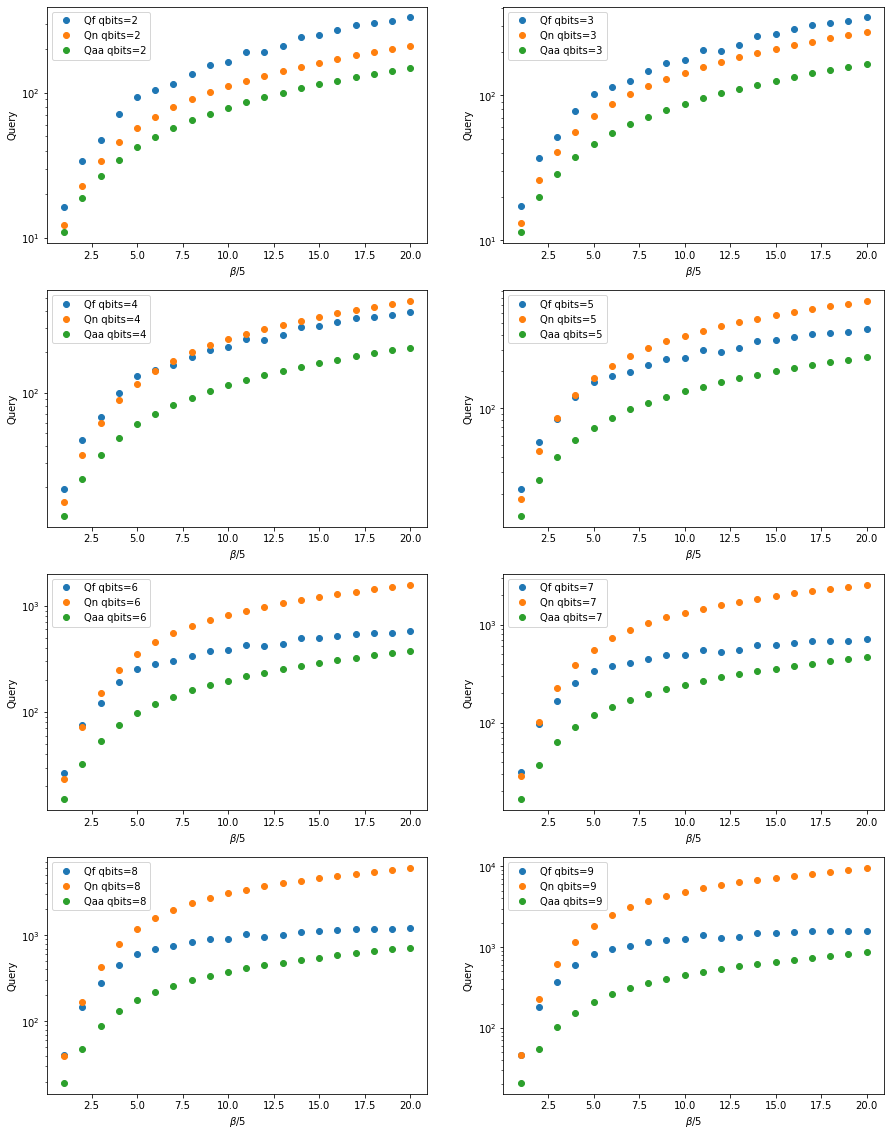

In [93]:
fig, axs = plt.subplots(4, 2, figsize=(15,20))
axs = axs.flatten()
for i in range(2,nmax+1):
    b = range(1,ntemp+1)
    axs[i-2].plot(b, Q[i-2], 'o', label='Qf qbits=%d' % i)
    axs[i-2].plot(b, Qn[i-2], 'o', label='Qn qbits=%d' % i)
    axs[i-2].plot(b, Qaa[i-2], 'o', label='Qaa qbits=%d' % i)
    axs[i-2].legend()
    axs[i-2].set_yscale('log')
    axs[i-2].set_ylabel('Query');
    axs[i-2].set_xlabel('$\\beta / 5$');

Text(0, 0.5, 'Query')

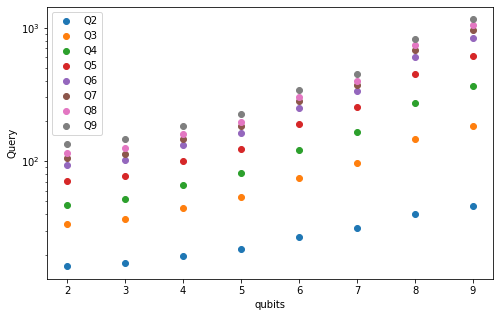

In [107]:
plt.figure(figsize=(8,5))
for i in range(2, nmax+1):
    plt.plot(range(2, nmax+1), Q[:,i-2], 'o', label='Q%s' % i)
plt.yscale('log')
plt.legend()
plt.xlabel('qubits')
plt.ylabel('Query')